In [18]:
import os
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

In [20]:
# Load data
stock_data = pd.read_csv(
    'Nifty_data.csv', 
    sep=',', 
    index_col='Date', 
    parse_dates=['Date']
)

In [21]:
# Handle missing values
stock_data = stock_data.fillna(method='ffill').fillna(method='bfill')

In [22]:
# Display the first few rows to check for missing values
print(stock_data.head())

                Symbol Series  Prev Close    Open     High    Low   Last  \
Date                                                                       
2007-11-27  MUNDRAPORT     EQ      440.00  770.00  1050.00  770.0  959.0   
2007-11-28  MUNDRAPORT     EQ      962.90  984.00   990.00  874.0  885.0   
2007-11-29  MUNDRAPORT     EQ      893.90  909.00   914.75  841.0  887.0   
2007-11-30  MUNDRAPORT     EQ      884.20  890.00   958.00  890.0  929.0   
2007-03-12  MUNDRAPORT     EQ      921.55  939.75   995.00  922.0  980.0   

             Close    VWAP    Volume      Turnover   Trades  \
Date                                                          
2007-11-27  962.90  984.72  27294366  2.687720e+15  19171.0   
2007-11-28  893.90  941.38   4581338  4.312770e+14  19171.0   
2007-11-29  884.20  888.09   5124121  4.550660e+14  19171.0   
2007-11-30  921.55  929.17   4609762  4.283260e+14  19171.0   
2007-03-12  969.30  965.65   2977470  2.875200e+14  19171.0   

            Deliverable V

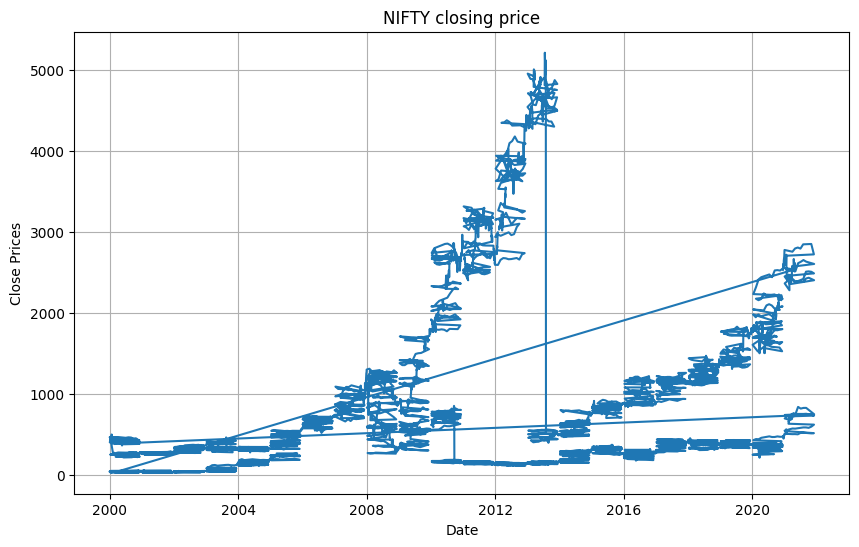

In [24]:
# Visualize the Stock’s Daily Closing Price
#plot close price
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Close Prices')
plt.plot(stock_data['Close'])
plt.title('NIFTY closing price')
plt.show()

<Axes: ylabel='Density'>

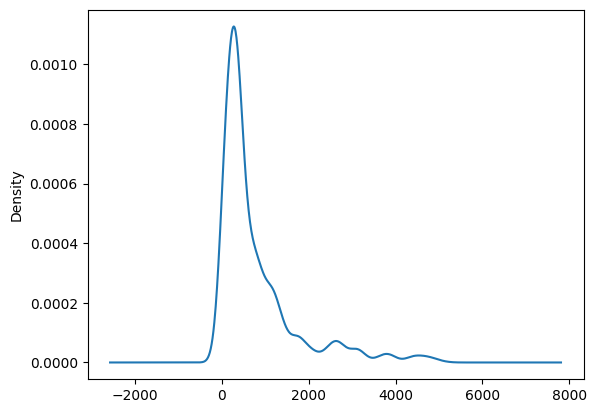

In [25]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

In [26]:
#Test for staionarity
def test_stationarity(timeseries):
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.show(block=False)
    print("Results of dickey fuller test")
    adft = adfuller(timeseries,autolag='AIC')
    # output for dft will give us without defining what the values are.
    #hence we manually write what values does it explains using a for loop
    output = pd.Series(adft[0:4],index=['Test Statistics','p-value','No. of lags used','Number of observations used'])
    for key,values in adft[4].items():
        output['critical value (%s)'%key] =  values
    print(output)

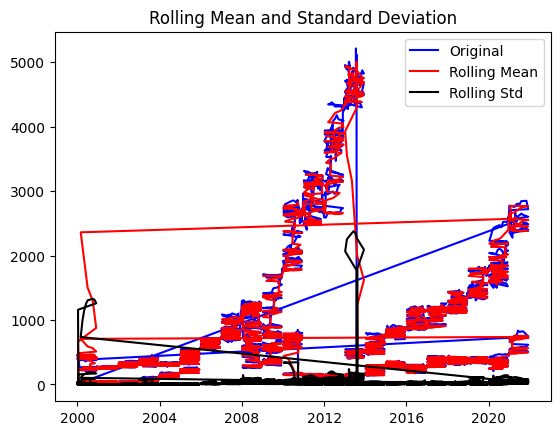

Results of dickey fuller test
Test Statistics                  -2.958495
p-value                           0.038957
No. of lags used                  9.000000
Number of observations used    9989.000000
critical value (1%)              -3.431005
critical value (5%)              -2.861829
critical value (10%)             -2.566924
dtype: float64


In [27]:
test_stationarity(df_close)

<Axes: ylabel='Density'>

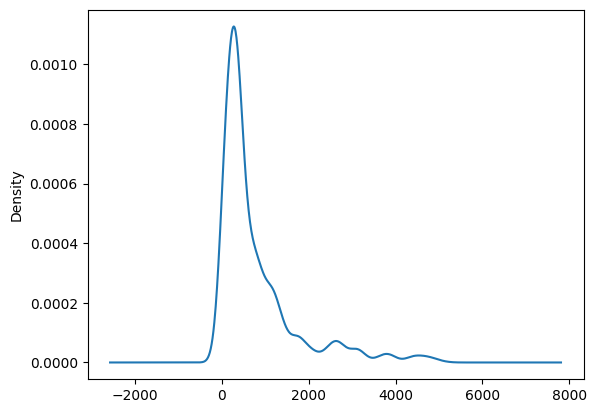

In [28]:
#Distribution of the dataset
df_close = stock_data['Close']
df_close.plot(kind='kde')

<Figure size 640x480 with 0 Axes>

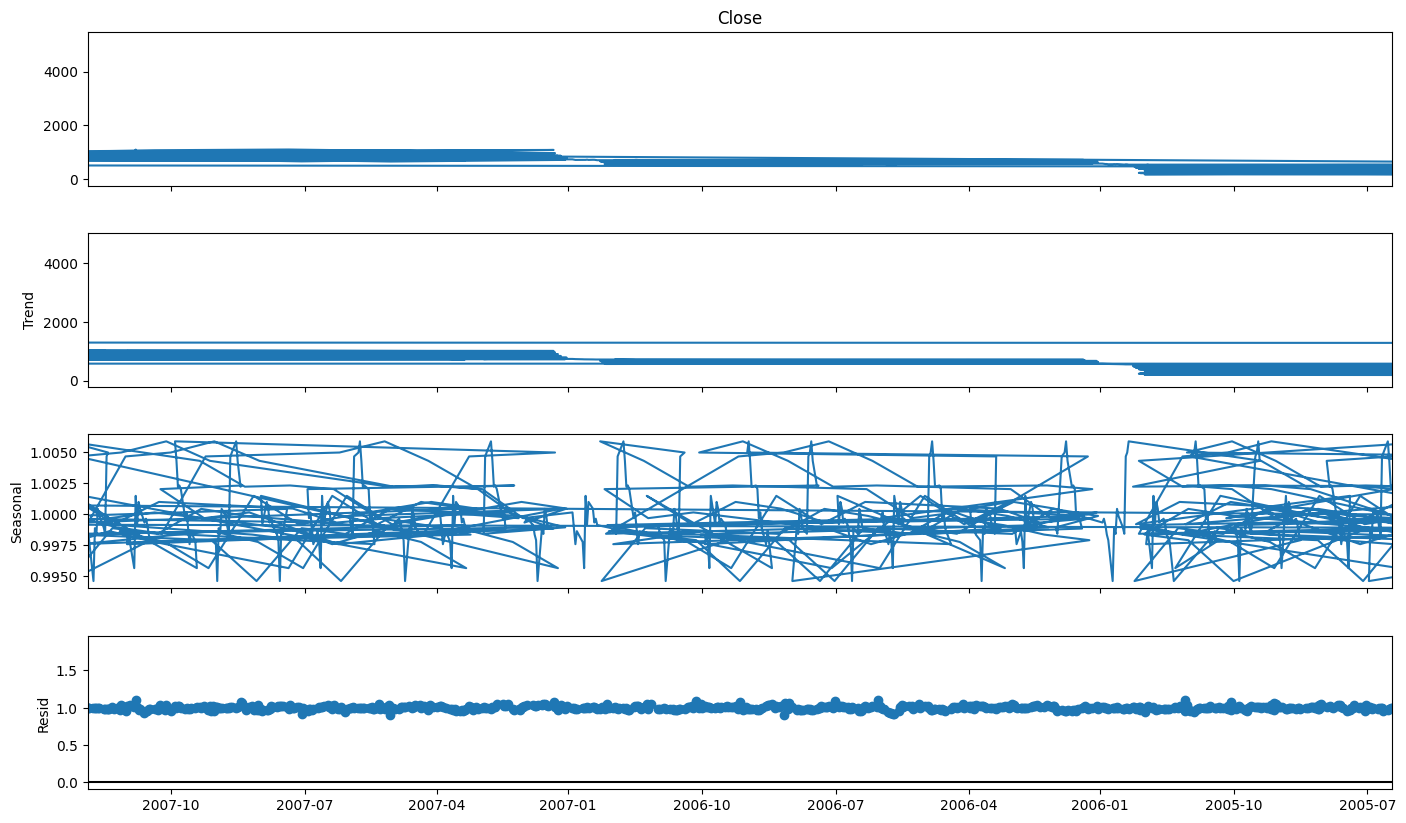

In [31]:
# Decompose time series
result = seasonal_decompose(stock_data['Close'], model='multiplicative', period=30)
fig = plt.figure()  
fig = result.plot()  
fig.set_size_inches(16, 9)

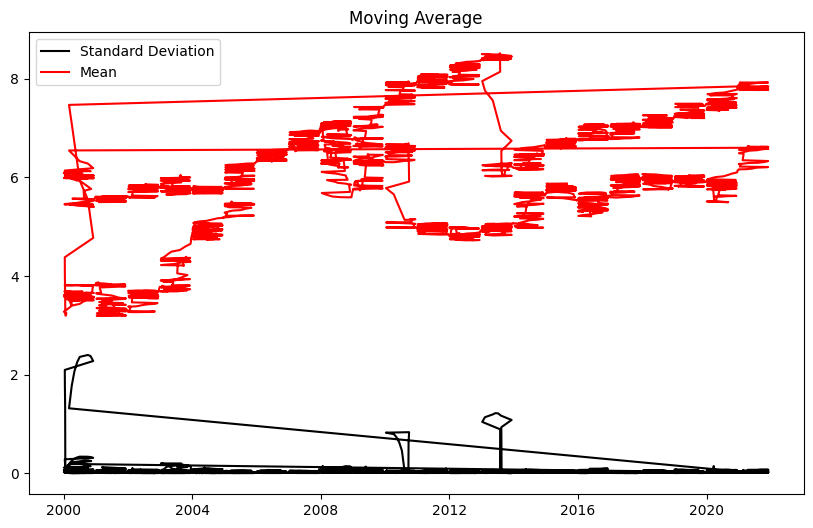

In [32]:
#if not stationary then eliminate trend
#Eliminate trend
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6
df_log = np.log(df_close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc='best')
plt.title('Moving Average')
plt.plot(std_dev, color ="black", label = "Standard Deviation")
plt.plot(moving_avg, color="red", label = "Mean")
plt.legend()
plt.show()

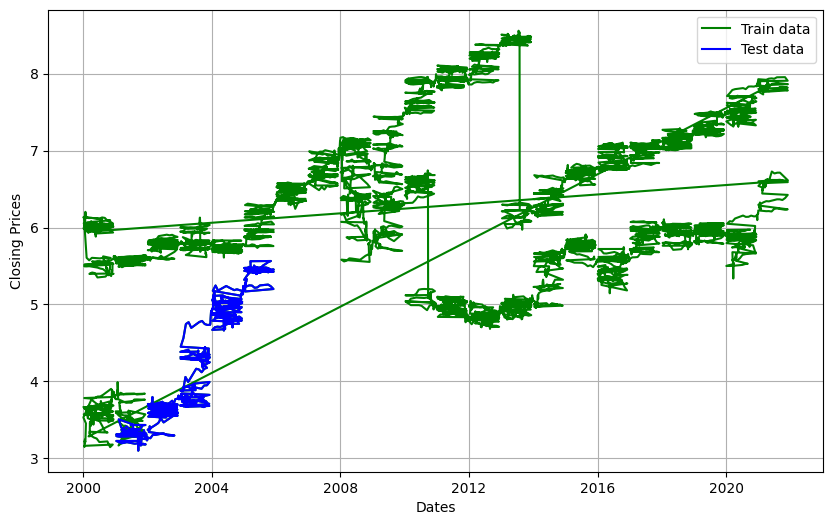

In [33]:
#split data into train and training set
train_data, test_data = df_log[3:int(len(df_log)*0.9)], df_log[int(len(df_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_log, 'green', label='Train data')
plt.plot(test_data, 'blue', label='Test data')
plt.legend()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-24640.235, Time=2.13 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-24638.495, Time=1.00 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-24638.493, Time=1.79 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-24641.891, Time=0.85 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-24636.512, Time=2.71 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 8.801 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8996
Model:               SARIMAX(0, 1, 0)   Log Likelihood               12321.945
Date:                Mon, 22 Jul 2024   AIC                         -24641.891
Time:                        13:05:37   BIC                         -24634.786
Sample:                             0   HQIC                        -24639.473
                               - 8996                             

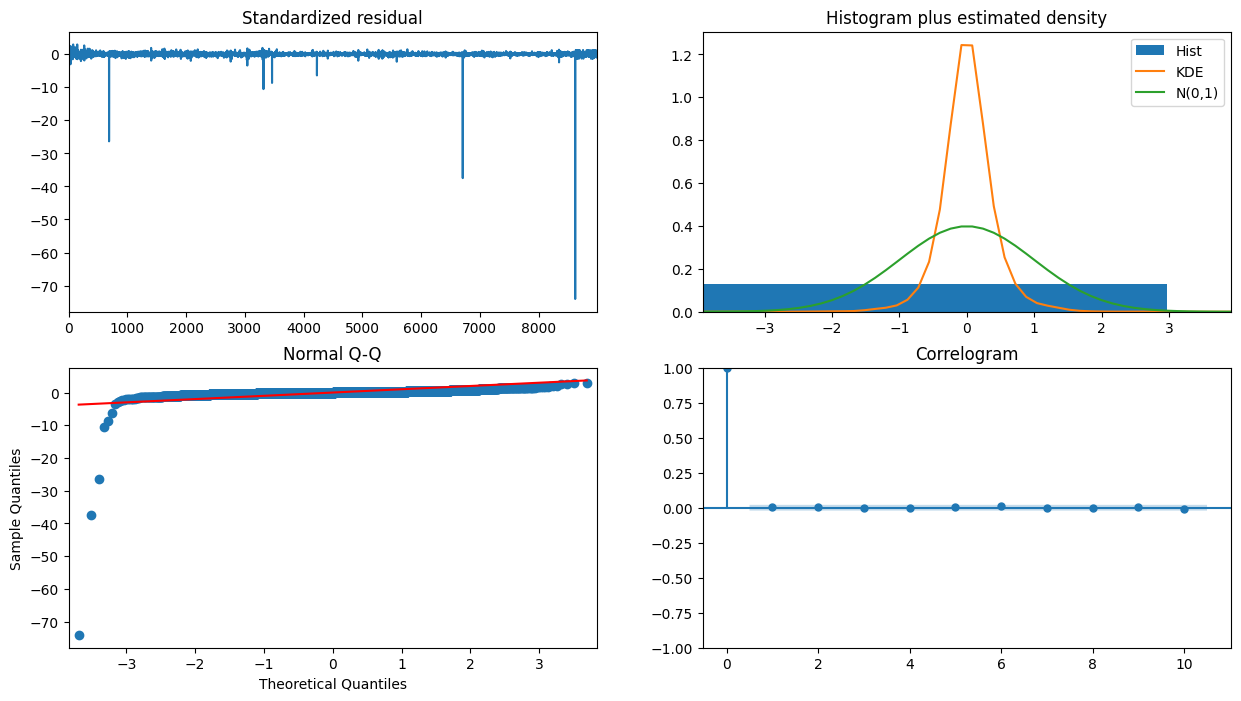

In [34]:
model_autoARIMA = auto_arima(train_data, start_p=0, start_q=0,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [36]:
# Fit ARIMA model
model = ARIMA(train_data, order=(1,1,2))
fitted = model.fit()

In [38]:
# Forecast
forecast = fitted.get_forecast(steps=len(test_data))
fc = forecast.predicted_mean
conf = forecast.conf_int(alpha=0.05)

In [39]:
# Convert forecast and confidence intervals to pandas Series
fc_series = pd.Series(fc, index=test_data.index)
lower_series = pd.Series(conf.iloc[:, 0], index=test_data.index)
upper_series = pd.Series(conf.iloc[:, 1], index=test_data.index)

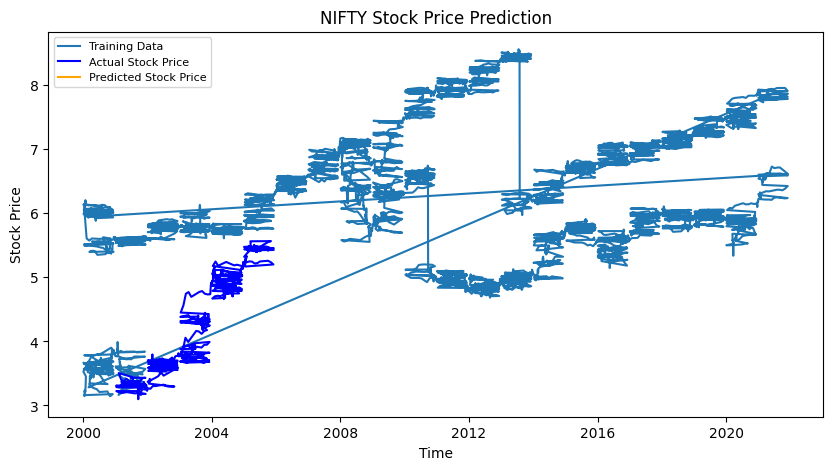

In [40]:
# Plot results
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='Training Data')
plt.plot(test_data, color='blue', label='Actual Stock Price')
plt.plot(fc_series, color='orange', label='Predicted Stock Price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.title('NIFTY Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend(loc='upper left', fontsize=8)
plt.show()

In [42]:
# report performance
mse = mean_squared_error(test_data, fc)
print('MSE: '+str(mse))
mae = mean_absolute_error(test_data, fc)
print('MAE: '+str(mae))
rmse = math.sqrt(mean_squared_error(test_data, fc))
print('RMSE: '+str(rmse))
mape = np.mean(np.abs(fc - test_data)/np.abs(test_data))
print('MAPE: '+str(mape))

MSE: 1.2328271910739714
MAE: 0.8617052984497993
RMSE: 1.1103275152287146
MAPE: nan
